# Synthetic satelite images

Airbus Ship Detection Challenge data consists of real world satellite pictures, which is highly inhomogeneous and naturally complex. In order to cope with complex problems, one should start with simple ones. Thus the idea to create a simple data consisting of synthetic satellite images. 

This should be treated as a playground data, that would help one to developed tools before working on actually data from the challenge.

**Note.** I am new to this kind of problems and during generating data I had no idea how to tackle ship detection problem. So I had no solution in mind that would influence the structure of this synthetic data.

## Kernel content

1. Overview of the generator
2. Distribution of the number of ships

In [1]:
import numpy as np
import scipy as sp
from scipy import ndimage
import skimage.transform as sk_trans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import uuid
import os
import pandas as pd
import imageio
import warnings
import imageio.core.util

# error and warning managing

def silence_imageio_warning(*args, **kwargs):
    pass

imageio.core.util._precision_warn = silence_imageio_warning

warnings.simplefilter('default')
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('error', RuntimeWarning)

### Overview of the generator

Each image consists of just 3 random synthetic elements:
1. Waves
2. Ships
3. Top noise

There is some global parameter `grid_div` which dissects an image into a square grid of size `grid_div` such that in each tile there is at most one ship.

1. **Waves**

Logically, the bigger `grid_div` the smaller waves.

In [2]:
img_size = 768

def random_waves(grid_div):
    
    min_freq = grid_div * 0.05
    max_freq = grid_div * 0.4
    
    x = np.linspace(0,img_size,img_size)
    freq = np.random.uniform(min_freq, max_freq)
    sin = 0.5 * np.sin(freq * x)
    noise = np.random.rand(img_size)
    sin_noise = noise + sin
    
    horizontal_noise = np.stack([sin_noise for i in range(img_size)])
    additional_noise = 0.2 * (np.random.rand(img_size, img_size) + 1)
    random_intensity = np.random.uniform(0.4, 1)
    horizontal_waves = random_intensity*(horizontal_noise + additional_noise)
    
    angle = np.random.uniform(0, 180)
    rotated = sk_trans.rotate(horizontal_waves, angle)
    
    cropped = rotated[150: 600, 150: 600]
    final_waves = sk_trans.resize(cropped, (img_size, img_size))
    
    return final_waves

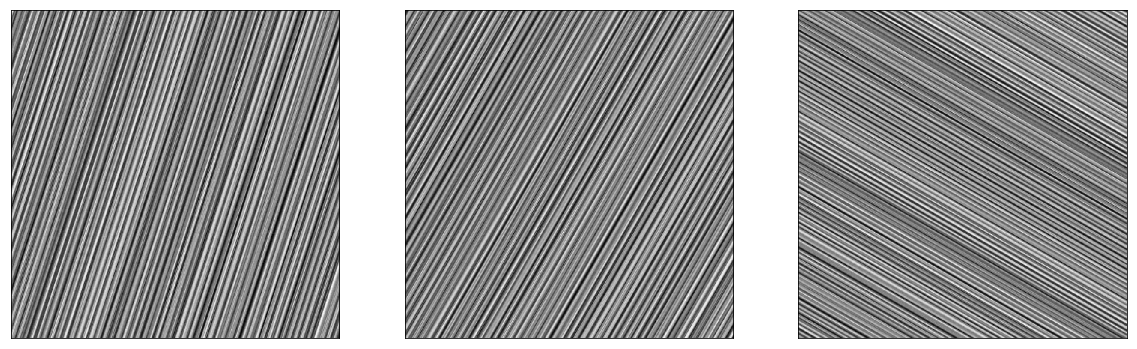

In [3]:
fig, axes = plt.subplots(1, 3, figsize = (20, 10), subplot_kw = {'xticks': [], 'yticks': []})

for ax in axes.flat:
    grid_div = int(np.random.uniform(3, 9))
    some_waves = random_waves(grid_div)
    ax.imshow(some_waves, cmap='binary')
    
plt.show()

2. **Ships**

In original data, all masks are of rectangle shape. We do the same here.

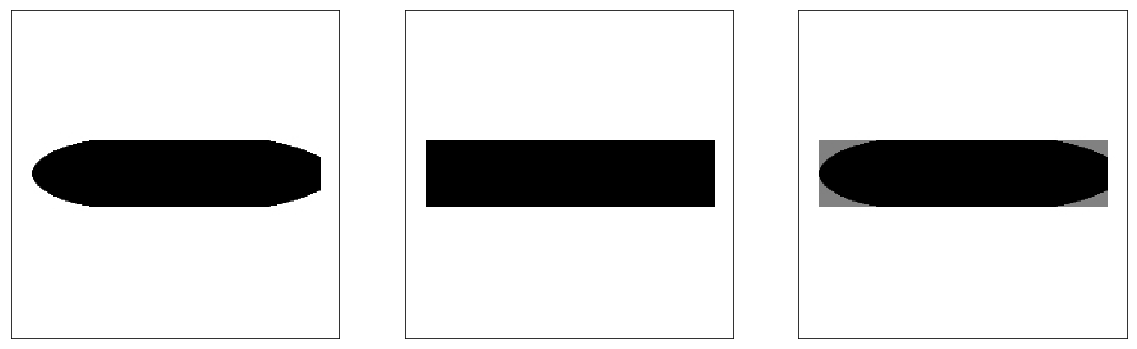

In [4]:
# Load the ship and fit the mask

loaded = np.loadtxt('ship.csv', dtype=float)
the_ship = loaded * 10 ** (-2)
the_mask = np.zeros_like(the_ship, dtype = np.uint8)
the_mask[102:154, 16:241] = 1

ship_size = 256

weighted_sum = cv2.addWeighted(the_mask.astype(float), 0.75, the_ship, 0.5, 0.5)
overlap = the_ship.copy()
ind = the_mask[:, :] > 0    
overlap[ind] = weighted_sum[ind]

fig, axes = plt.subplots(1, 3, figsize = (20, 10), subplot_kw = {'xticks': [], 'yticks': []})
axes[0].imshow(the_ship, cmap='binary')
axes[1].imshow(the_mask, cmap='binary')
axes[2].imshow(overlap, cmap='binary')
plt.show()

In [5]:
# Some random transformations. Note that we transform mask in parallel

def random_ship_streach(base_ship, base_mask):
    x_streach = np.random.uniform(0.5, 1.5)
    y_streach = np.random.uniform(0.8, 1.2)

    x_streach_size = int(ship_size * x_streach)
    y_streach_size = int(ship_size * y_streach)

    streached_ship = sk_trans.resize(base_ship, (y_streach_size, x_streach_size))
    streached_mask = sk_trans.resize(base_mask, (y_streach_size, x_streach_size))

    y_size, x_size = streached_ship.shape

    if x_size == y_size:
        squared_ship = streached_ship
        squared_mask = streached_mask
    elif x_size < y_size:
        squared_ship = np.zeros((y_size, y_size))
        squared_mask = np.zeros((y_size, y_size))
        diff = y_size - x_size
        x_offset = int(diff / 2)
        squared_ship[:, x_offset: x_offset + x_size] = streached_ship
        squared_mask[:, x_offset: x_offset + x_size] = streached_mask
    else:
        squared_ship = np.zeros((x_size, x_size))
        squared_mask = np.zeros((x_size, x_size))
        diff = x_size - y_size
        y_offset = int(diff / 2)
        squared_ship[y_offset: y_offset + y_size] = streached_ship
        squared_mask[y_offset: y_offset + y_size] = streached_mask

    resized_ship = sk_trans.resize(squared_ship, (ship_size, ship_size))
    resized_mask = sk_trans.resize(squared_mask, (ship_size, ship_size))
    
    return resized_ship, resized_mask

def random_ship_rotate(ship, mask):
    angle = np.random.uniform(0, 360)
    rotated_ship = sk_trans.rotate(ship, angle)
    rotated_mask = sk_trans.rotate(mask, angle)
    return rotated_ship, rotated_mask

def random_tranform_ship(base_ship, base_mask, grid_div):
    streached_ship, streached_mask = random_ship_streach(base_ship, base_mask)
    rotated_ship, rotated_mask = random_ship_rotate(streached_ship, streached_mask)
    maxsize = 0.9* img_size / grid_div
    scale = np.random.uniform(0.5, 1)
    final_size = int(maxsize * scale)
    random_ship = sk_trans.resize(rotated_ship, (final_size, final_size))
    random_ships_mask = sk_trans.resize(rotated_mask, (final_size, final_size))
    return random_ship, random_ships_mask

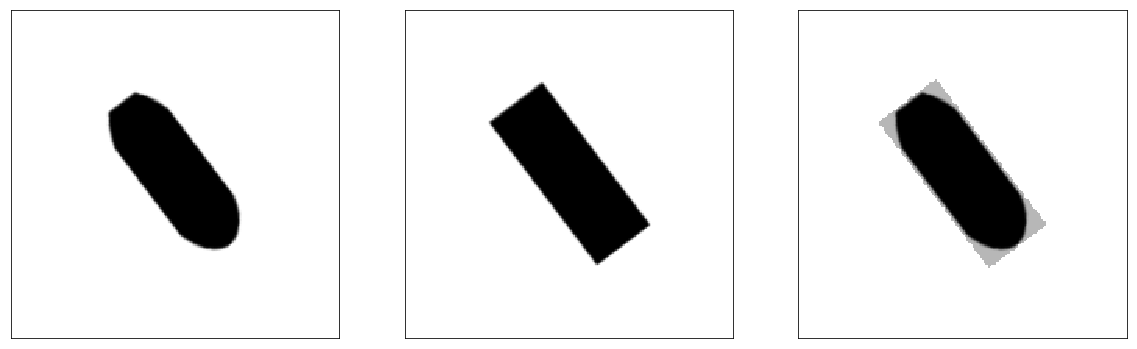

In [19]:
# Example

grid_div = int(np.random.uniform(3, 9))

random_ship, random_ships_mask = random_tranform_ship(the_ship, the_mask, grid_div)

weighted_sum = cv2.addWeighted(random_ships_mask.astype(float), 0.75, random_ship, 0.5, 0.5)
overlap = random_ship.copy()
ind = random_ships_mask[:, :] > 0    
overlap[ind] = weighted_sum[ind]

fig, axes = plt.subplots(1, 3, figsize = (20, 10), subplot_kw = {'xticks': [], 'yticks': []})
axes[0].imshow(random_ship, cmap='binary')
axes[1].imshow(random_ships_mask, cmap='binary')
axes[2].imshow(overlap, cmap='binary')
plt.show()

We can put synthetic ships on blank backgorund and create a list of associated masks

In [7]:
# zero_one function is for decoding/encoding purpose. Simply, 1-there is a mask, 0-there is not.

def zero_one(t):
    if t == 0:
        return 0
    else:
        return 1  

def add_ship(base_ship, base_mask, canvas, masks, grid_div, x_offset, y_offset):
    random_ship, random_ships_mask = random_tranform_ship(base_ship, base_mask, grid_div)
    random_intensity = np.random.uniform(0.8, 1.2)
    random_ship *= random_intensity
    y_top = y_offset+random_ship.shape[0]
    x_top = x_offset+random_ship.shape[1]
    if y_top < img_size and x_top < img_size:
        canvas[y_offset:y_top,x_offset:x_top] = np.maximum(canvas[y_offset:y_top,x_offset:x_top], random_ship)
        mask_background = np.zeros((img_size, img_size))
        mask_background[y_offset:y_top,x_offset:x_top] = random_ships_mask
        mask_binary = np.vectorize(zero_one)(mask_background).astype(np.uint8)
        masks.append(mask_binary)      
        
def random_ships(base_ship, base_mask, canvas, masks, grid_div, density):
    
    step = img_size / grid_div
    x_offset = int(step / 4)
    for x in range(grid_div):
        y_offset = int(step / 4)
        for y in range(grid_div):
            rand = np.random.uniform(0, 1)
            if rand < density:
                add_ship(base_ship, base_mask, canvas, masks, grid_div, x_offset, y_offset)
            y_offset += int(step)
        x_offset += int(step)         

    return canvas, masks

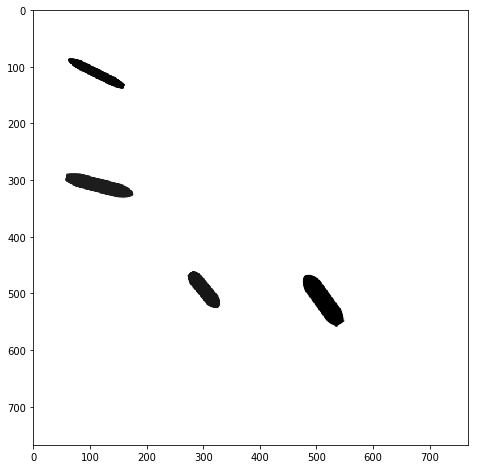

In [8]:
canvas = np.zeros((img_size, img_size))
masks = []

canvas, masks = random_ships(the_ship, the_mask, canvas, masks, 4, 0.2)

plt.figure(figsize = (8,8))
plt.imshow(canvas, cmap='binary')
plt.show()

Top noise. Just interpolated rough white noise (warning, interpolation functions sometimes spits runtime error)

In [9]:
def top_noise():
    noise_size = int(np.random.uniform(4, 10))
    noise = 0.75 * ( np.random.rand(noise_size,noise_size) + 1)
    X = np.linspace(0, noise_size - 1, noise_size)
    Y = np.linspace(0, noise_size - 1, noise_size)
    x, y = np.meshgrid(X, Y)

    f = sp.interpolate.interp2d(x, y, noise, kind='cubic')

    X_new = np.linspace(0, noise_size - 1, img_size)
    Y_new = np.linspace(0, noise_size - 1, img_size)

    top_noise = f(X_new, Y_new)
    return top_noise

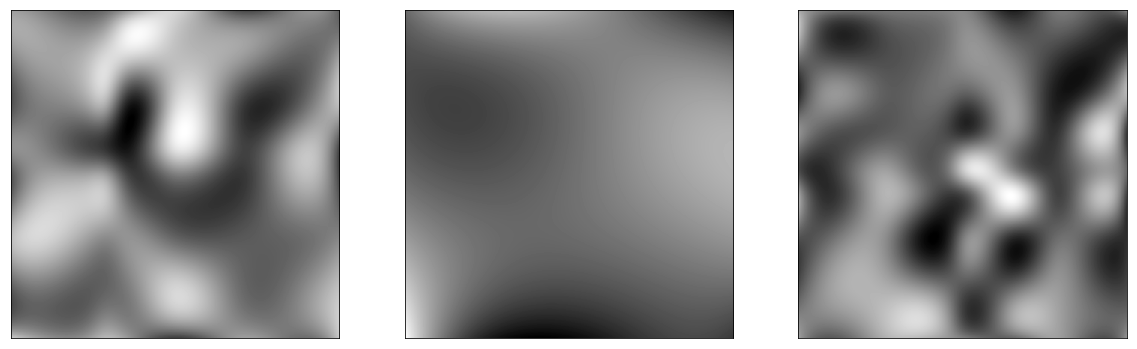

In [10]:
# Examples

fig, axes = plt.subplots(1, 3, figsize = (20, 10), subplot_kw = {'xticks': [], 'yticks': []})

for ax in axes.flat:
    some_noise = top_noise()
    ax.imshow(some_noise, cmap='binary')
    
plt.show()

In [11]:
# Combined

def random_img_mask(base_ship, base_mask):
    grid_div = int(np.random.uniform(3, 9))
    density = np.random.uniform(0, 0.03)
    
    canvas = random_waves(grid_div) + top_noise()
    masks = []
    
    img, masks = random_ships(base_ship, base_mask, canvas, masks, grid_div, density)
    
    return img, masks

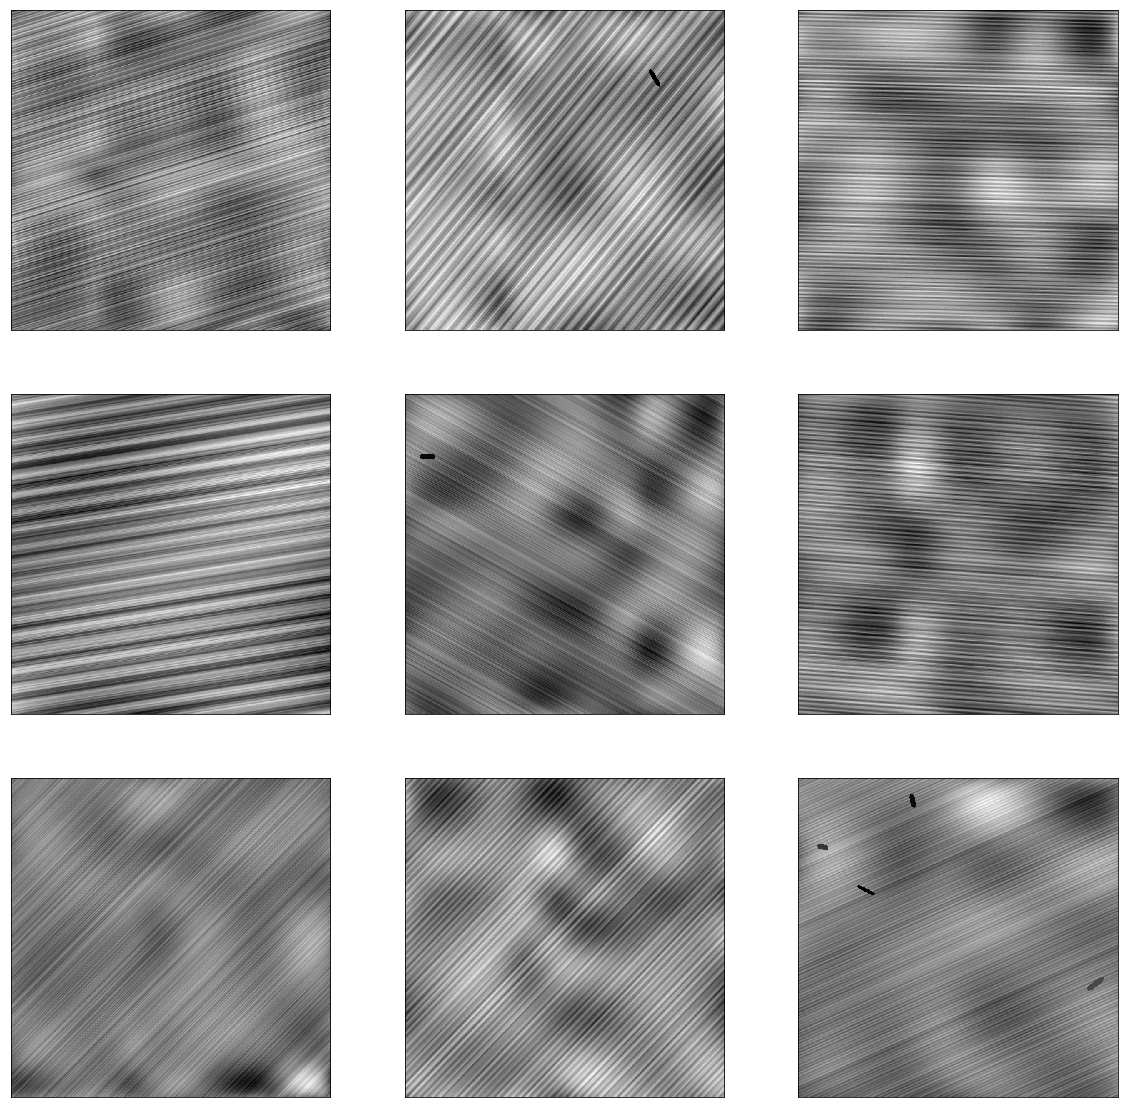

In [12]:
# Examples. Random 9 images

fig, axes = plt.subplots(3, 3, figsize = (20, 20), subplot_kw = {'xticks': [], 'yticks': []})

for ax in axes.flat:
    while True:
        try:
            some_img, masks = random_img_mask(the_ship, the_mask)
            break
        except Warning:
            pass
    ax.imshow(some_img, cmap='binary')
    
plt.show()

**Note** that ships are quite rare. This is because we imitate the original Airbus data which is simillar. See the distribution part at the end of this notebook.

We use here the same run lenght encoding as it is used in Airbus challenge.

In [13]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

Generating images

In [ ]:
# the following snippet saves 1000 imgs as jpg files to directory  generated_data_final/train 
# and creates a csv file generated_data_final/train_ship_segmentations.csv of the same format as in Airbus Competition

col_names = ['ImageId', 'EncodedPixels']
df = pd.DataFrame(columns = col_names)

no_of_imgs = 1000

for i in range(no_of_imgs):
    while True:
        try:
            image, masks = random_img_mask(the_ship, the_mask)
            break
        except Warning:
            pass
    filename = str(uuid.uuid4()) + '.jpg'
    if masks == []:
        df.loc[len(df)] = [filename, None]
    else:
        for _, mask in enumerate(masks):
            encoded_mask = rle_encode(mask)
            df.loc[len(df)] = [filename, encoded_mask]
    im_path = os.path.join('generated_data_final/train', filename)
    imageio.imwrite(im_path, image)
    if i % 10 == 0 and i > 1:
        print('{} picture generated'.format(i))

print('{} images and {} records generated'.format(no_of_imgs, len(df)))

df.to_csv('generated_data_final/train_ship_segmentations.csv', index = False)

**Note** It is important to repeat the same process for the test set or generate data and make a split. However, everything is generated randomly from uniform distributions, so it does not make any difference.

## Distribution of the number of ships

Let us first have a look at the distribution of the number of ships in the oryginal Airbus Challenge data.

In [14]:
current_dir = os.getcwd()
parent_of_current_dir = os.path.dirname(current_dir)
ship_detection_dir = os.path.join(parent_of_current_dir, 'ship-detection')
DATA_PATH = os.path.join(ship_detection_dir, 'data')
df_oryginal = pd.read_csv(DATA_PATH + '/train_ship_segmentations.csv')

imgs = df_oryginal['ImageId'].unique().size
imgs_without_ships = df_oryginal['EncodedPixels'].isna().sum(axis=0)

print("There are {} imgs in which {} have no ships in it".format(imgs, imgs_without_ships))

There are 104070 imgs in which 75000 have no ships in it


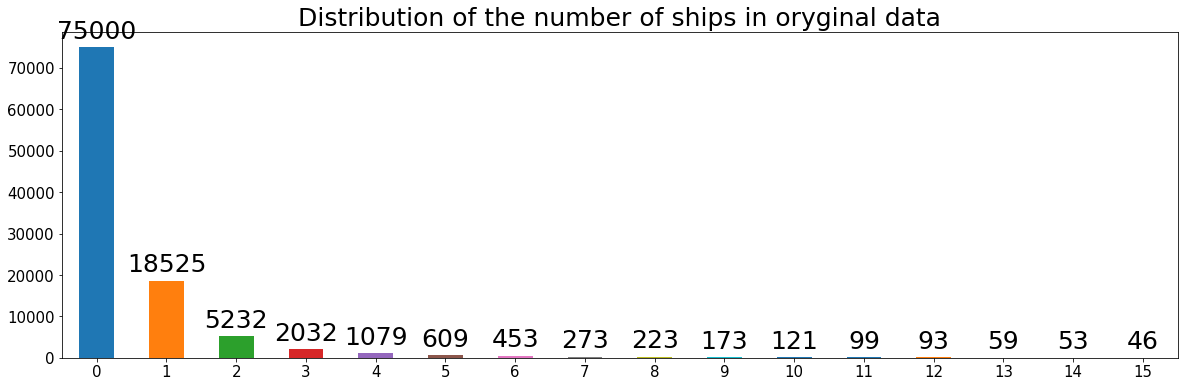

In [15]:
df_with_ships = df_oryginal.loc[~df_oryginal['EncodedPixels'].isna()]
df_imgId_count = df_with_ships.groupby(['ImageId']).size().reset_index(name='count')

series_count = df_imgId_count['count'].value_counts()
series_count.loc[0] = imgs_without_ships
series_count = series_count.sort_index()

count_values = series_count.values
values = np.linspace(0, 15, 16)

plt.figure(figsize=(20,6))
ax = series_count.plot(kind='bar')

plt.xticks(rotation=0, fontsize = 15)
plt.yticks(rotation=0, fontsize = 15)

rects = ax.patches

# Make some labels.
labels = [series_count[i] for i in range(16)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1000, label,
            ha='center', va='bottom', fontsize=25)

plt.title('Distribution of the number of ships in oryginal data', fontsize=25)
plt.show()

Let us compare it with distribution of the number of ships in the synthetic data (60000 generated imgs)

In [16]:
df_train = pd.read_csv('generated_data/train_ship_segmentations.csv')

imgs = df_train['ImageId'].unique().size
imgs_without_ships = df_train['EncodedPixels'].isna().sum(axis=0)

print("There are {} imgs in which {} have no ships in it".format(imgs, imgs_without_ships))

There are 60000 imgs in which 40776 have no ships in it


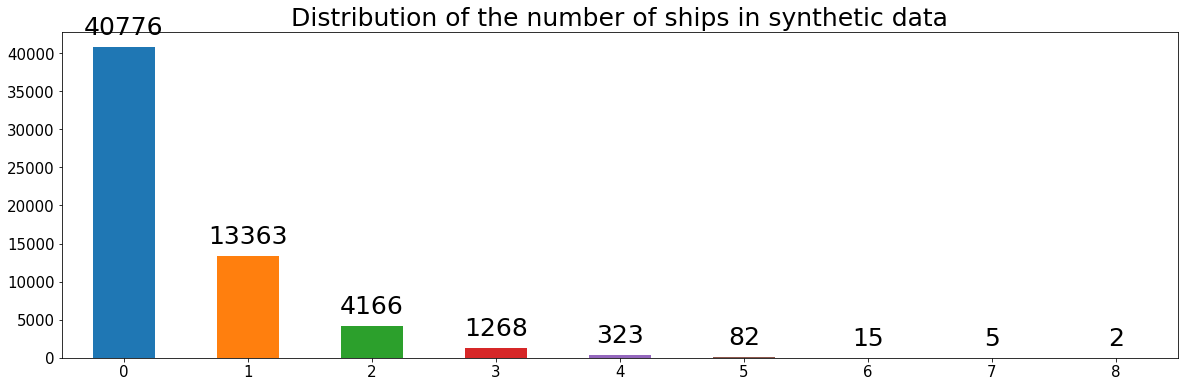

In [17]:
df_with_ships = df_train.loc[~df_train['EncodedPixels'].isna()]
df_imgId_count = df_with_ships.groupby(['ImageId']).size().reset_index(name='count')

series_count = df_imgId_count['count'].value_counts()
series_count.loc[0] = imgs_without_ships
series_count = series_count.sort_index()

count_values = series_count.values
values = np.linspace(0, 8, 9)

plt.figure(figsize=(20,6))
ax = series_count.plot(kind='bar')

plt.xticks(rotation=0, fontsize = 15)
plt.yticks(rotation=0, fontsize = 15)

rects = ax.patches

# Make some labels.
labels = [series_count[i] for i in range(9)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1000, label,
            ha='center', va='bottom', fontsize=25)

plt.title('Distribution of the number of ships in synthetic data', fontsize=25)
plt.show()